In [13]:
# !nvidia-smi
# !pip install keras
# !pip install torch
# !pip install tensorflow-gpu
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8647337322485430950
xla_global_id: -1
]


In [12]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10 as cifar
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical as one_hot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
(X_train, y_train), (X_test, y_test) = cifar.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

X_train[21045]:


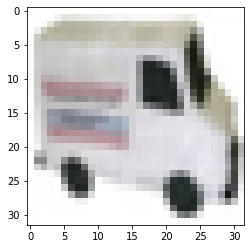

X_train[32587]:


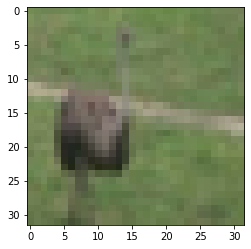

X_train[31108]:


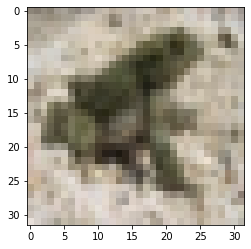

In [4]:
for i in np.random.randint(len(X_train), size=3):
    print(f"X_train[{i}]:")
    plt.imshow(X_train[i] , cmap='gray')
    plt.show()

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the data: using Z-score
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train = (X_train - X_train_mean) / X_train_std + 1e-10 # 1e-10 is to avoid zero division
X_test = (X_test - X_train_mean) / X_train_std + 1e-10

In [6]:
# We need to one-hot encode the labels for the softmax classifier in the output layer
Y_train = one_hot(y_train, 10)
Y_test = one_hot(y_test, 10)

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolutional layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

# 3rd convolutional layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

# 4th convolutional layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.55))

# Flatten the output of the convolutional layers into a 1D vector for the fully connected layers
model.add(Flatten())
# Fully connected layer for the final classification
model.add(Dense(10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [9]:
# We perform data augmentation to avoid overfitting
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False)
datagen.fit(X_train)

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(datagen.flow(X_train, Y_train, batch_size=64), epochs=100, steps_per_epoch=X_train.shape[0] // 64, verbose=1, validation_data=(X_test, Y_test))

# Save the model
model.save('cifar10_model.h5')



c:\users\mayan\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\mayan\AppData\Local\Temp/ipykernel_10988/1516067248.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64), epochs=100, steps_per_epoch=X_train.shape[0] // 64, verbose=1, validation_data=(X_test, Y_test))


Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 2.2051 - accuracy: 0.3705

KeyboardInterrupt: 